<a href="https://colab.research.google.com/github/SethupathyM/Unsupervised_ML_Clustering_and_Sentiment_Analysis_Zomato_Restaurant/blob/main/Zomato_Restaurant_Clustering_and_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import warnings
warnings.filterwarnings('ignore')

import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.stem import PorterStemmer, LancasterStemmer

from yellowbrick.cluster import KElbowVisualizer
from wordcloud import WordCloud

import inflect
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import DBSCAN
from textblob import TextBlob

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
import plotly.express as px

from collections import Counter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/Mydrive')

 **Loading Zomato Restaurant names and Metadata CSV file**

In [ ]:
# Loading the CSV file
df = pd.read_csv('/content/Mydrive/MyDrive/Capstone_Project_Unsupervised_ML_Zomato_Restaurant_Clustering_and_Sentiment_Analysis/Zomato Restaurant names and Metadata.csv')

In [ ]:
# Shape
df.shape

In [ ]:
# Head
df.head()

In [ ]:
# Info
df.info()

In [ ]:
# Null values
# Percentage of null values for each features
# print(list(df.columns))

for col in list(df.columns):
  if ((df[col].isnull().sum())/(len(df[col]))*100) > 50:
    # print((df[col].isnull().sum())/(len(df[col]))*100)
    print('Feature with more than 50% of the observations are NULL values:',col)

# As in the feature 'Collections' more than 50% of the observations are NULL values, so feature 'Collections' is droppped

In [ ]:
# Dropping the 'Collections' feature
df.drop(columns = 'Collections',axis =1,inplace = True)

# Removing the observations with null values in 'Timings' feature
df.dropna(axis = 0,inplace = True)

# Print
print('Shape:',df.shape)
print(df.info())

In [ ]:
# Summary
df.describe()

In [ ]:
# Replacing empty space and comma in 'Cuisine' feature
df['Cuisines'] = df['Cuisines'].str.replace(' ','')
df['Cuisines'] = df['Cuisines'].str.replace(',',', ')

In [ ]:
# Unique set of Cuisines
print('Number of Unique set of Cuisines : ',len(df['Cuisines'].unique()))
print(list(df['Cuisines'].unique()))

In [ ]:
# Spliiting with 'comma' and empty space
cuisine_list = df.Cuisines.str.split(', ')
# print(cuisine_list)

In [ ]:
# Top 10 Cuisines
clusterlist = {}
for names in cuisine_list:
    for name in names:
      # print(name)
      if (name in clusterlist):
        clusterlist[name]+=1
        # print(clusterlist)
      else:
         clusterlist[name]=1
# Create a cuis dataframe
cuis_df = pd.DataFrame(clusterlist.values(),index = clusterlist.keys(),columns = {'Cuisine count in Restaurants'}).reset_index()

# Sort the dataframe in descending order
cuis_df.sort_values(by = 'Cuisine count in Restaurants',ascending = False,inplace = True)

#Pick the 10 restaurant most nominated 
top_10_cuis = cuis_df[0:10]

print('The Top 10 Cuisines are:\n',top_10_cuis)

In [ ]:
# Visualization of Cuisines Count
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = cuis_df,x = cuis_df['index'],y = cuis_df['Cuisine count in Restaurants'],palette=['#D90077','#FBBEDE','#E090DF','#A44CD3','#8800C7'])
plt.title('Cuisines Count',fontweight='bold')
plt.xticks(rotation = 90,fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [ ]:
# df.head()

In [ ]:
# Visualization of words from 'Cuisines' feature
df['Cuisines']= df['Cuisines'].astype(str)

ps = PorterStemmer() 
df['Cuisines']=df['Cuisines'].map(lambda x: ps.stem(x))
long_string = ','.join(list(df['Cuisines'].values))
print(long_string)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# df.head()

In [ ]:
# Most nominated words from 'Cuisine' feature
words_list = clusterlist.keys()
strr = ' '
for i in words_list:
    strr=strr+i+' '
    
wordcloud = WordCloud(background_color='white',min_font_size = 1,colormap = 'Paired').generate(strr) 
wordcloud.to_image()


In [ ]:
# Number of Unique Restaurant
print('Number of Unique Restaurants:',df['Name'].nunique())

In [ ]:
# 'Cuisine' feature
# Replacing ',' 
df['Cost'] = df['Cost'].str.replace(',','')

# Converting 'cost' feature to integer datatype
df['Cost'] = df['Cost'].apply(lambda x:int(x))

In [ ]:
# Creating DataFrame with Restaurant names and their respective cost
restaurant_cost = pd.DataFrame(df.groupby('Name').agg({'Cost':'mean'})).reset_index()
restaurant_cost.sort_values(by = 'Cost',ascending = False,inplace= True)
# restaurant_cost.head()

In [ ]:
# Visualization of Restaurant names and their respective cost
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = restaurant_cost,x = restaurant_cost['Name'],y = restaurant_cost['Cost'],palette=['#006884','#00990E','#89DBEC','#ED0026','#FA9D00','#B00051','#F68370','#FEABB9','#6E006C','#CF97D7','#5B5B5B'])
plt.title('Cost of Restaurants',fontweight='bold')
plt.xticks(rotation = 90,fontsize = 14)
plt.yticks(fontsize = 18)
plt.show()

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(df[['Cuisines','Links','Timings']])

Function for Text Preprocessing

In [ ]:
# Functions
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

# Applying functions
col_lsts = ['Links','Cuisines','Timings']
for col_lst in col_lsts:
  df[col_lst] = normalize(df[col_lst])

In [ ]:
# Dataset after text preprocessing
df.head()

**Preprocessing the dataset for Clustering models**

In [ ]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words= 'english')
X = vectorizer.fit_transform(df['Cuisines'])

In [ ]:
X.shape
# we have 50 unique words

In [ ]:
# Type of X object
type(X)

In [ ]:
# Converting 'X' object to array
X = X.toarray()

In [ ]:
type(X)

**Elbow method to find appropriate 'K' value**

In [ ]:
# 'k-means++' would initialize the centroids far from each other because intializing the centroids nearby could lead to improper clustering

In [ ]:
# Function to find appropriate 'K' value
def KElbowvisualizer(metric):
  model = KMeans(init="k-means++",max_iter=300,random_state=0)
  plt.figure(figsize=(10,5))
  sns.set(font_scale = 1)
  visualizer = KElbowVisualizer(model, k=(2,20),metric= metric, timings= False, locate_elbow= True)
  # plt.title(fontweight='bold')
  # # Fit the data to the visualize
  visualizer.fit(X)  
  visualizer.poof()

In [ ]:
# KElbowvisualizer with metric as 'distortion
KElbowvisualizer('distortion')

In [ ]:
# KElbowvisualizer with metric as 'calinski_harabasz'
KElbowvisualizer('calinski_harabasz')

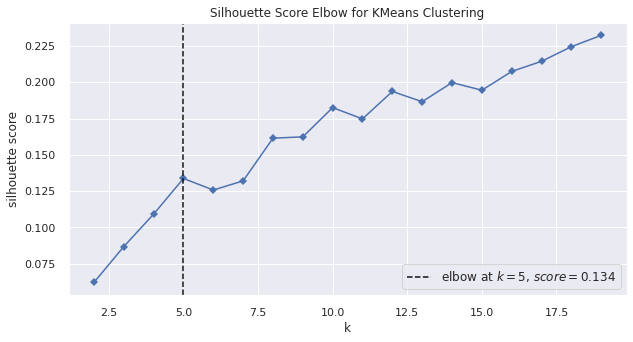

In [ ]:
# KElbowvisualizer with metric as 'silhouette'
KElbowvisualizer('silhouette')

Appropriate **K** value was found to be **14** 

**K Means Clustering**

In [ ]:
# looks like we can go with 14 clusters.
# Creating an object for K Means clustering
kmeans= KMeans(n_clusters=14, init= 'k-means++',max_iter=300, n_init=1,random_state = 0)

In [ ]:
# MOdel fit
kmeans.fit(X)

KMeans(n_clusters=14, n_init=1, random_state=0)

In [ ]:
#predict the labels of clusters.
labels = kmeans.fit_predict(X)

In [ ]:
# Clusters center
clusters_center = kmeans.cluster_centers_

In [ ]:
# Testin

X_new= vectorizer.transform([df['Cuisines'][15]])

y_pred_new= kmeans.predict(X_new)[0]

y_pred_new

2

In [ ]:
# Silhouette score is for model validation for K-means,Hierarichical clustering.
# Silhouette Coefficient ranges between -1 to +1.
# Higher the Silhouette Coefficient better the clustering.

**Model Validation**

In [ ]:
# Model Validation
# silhouette score of my clusters
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, kmeans.labels_))

Silhouette Coefficient: 0.179


For n_clusters = 10 The average silhouette_score is : 0.1825
For n_clusters = 11 The average silhouette_score is : 0.1747
For n_clusters = 12 The average silhouette_score is : 0.1937
For n_clusters = 13 The average silhouette_score is : 0.1866
For n_clusters = 14 The average silhouette_score is : 0.1998
For n_clusters = 15 The average silhouette_score is : 0.1945


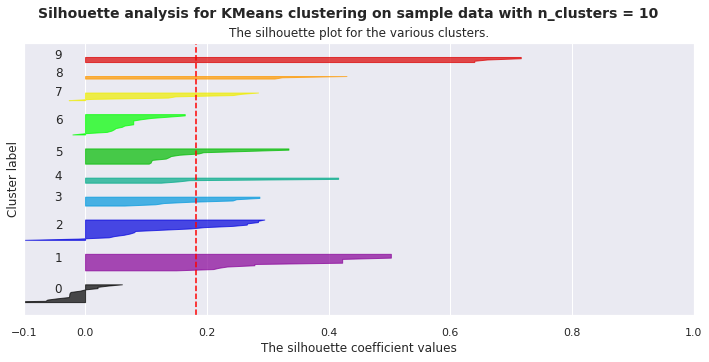

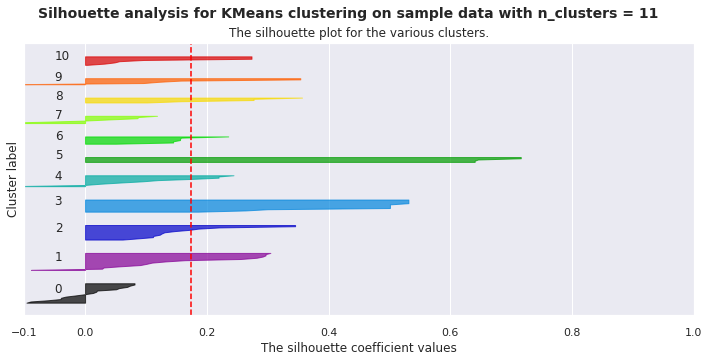

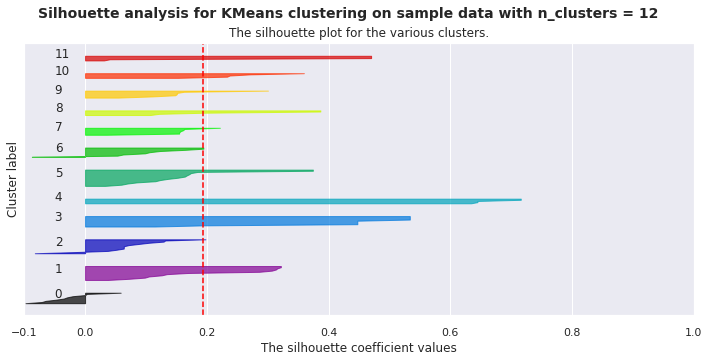

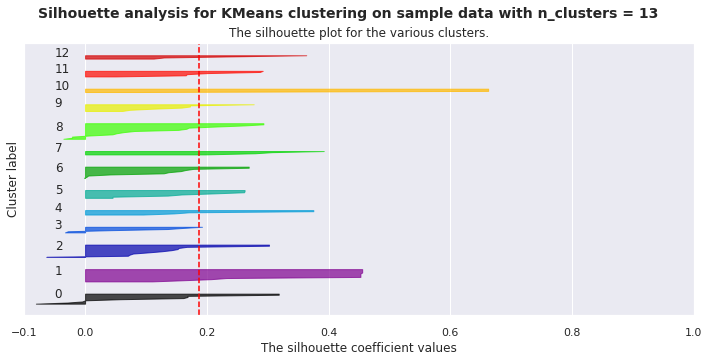

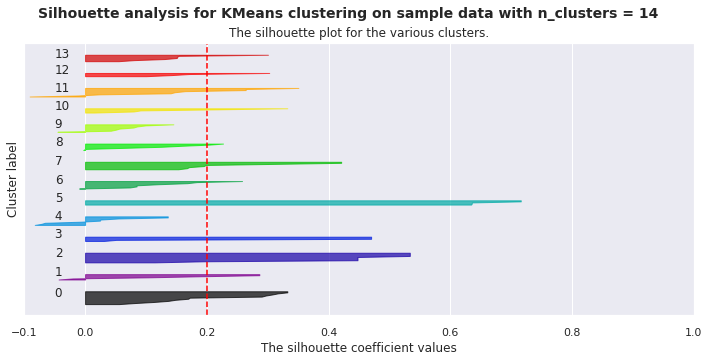

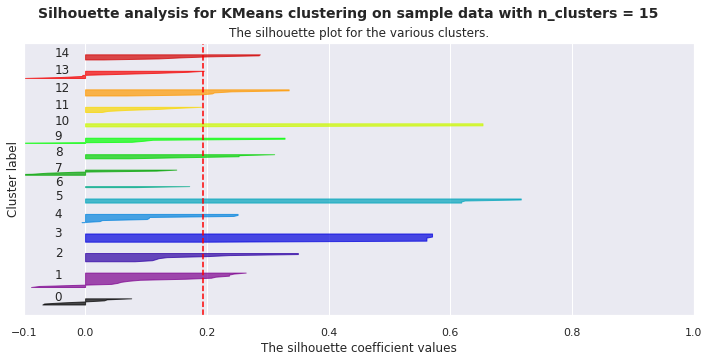

In [ ]:
# Evaluation
range_n_clusters = [10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init= 'k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", n_clusters,
    #       "The average silhouette_score is :", round(silhouette_avg,4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,4))
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Creating new feature to store labels
df['Kmeans_labels'] = kmeans.labels_

In [ ]:
# Creating a DataFrame for KMeans Labels visualization
Kmeans_labels_count = pd.DataFrame(df.groupby(['Kmeans_labels'])['Cuisines'].count()).reset_index()

In [ ]:
# Function for Labels with n number of observations
def labelsnobs(dataframe,x_value,y_value,palette_type,title,y_label):
  plt.figure(figsize = (20, 8))
  sns.set(font_scale = 2)
  sns.barplot(data = dataframe,x = x_value,y = y_value,palette=palette_type)
  plt.title(title,fontweight='bold')
  plt.ylabel(y_label)
  plt.xticks(rotation = 90,fontsize = 14)
  plt.yticks(fontsize = 18)
  plt.show()

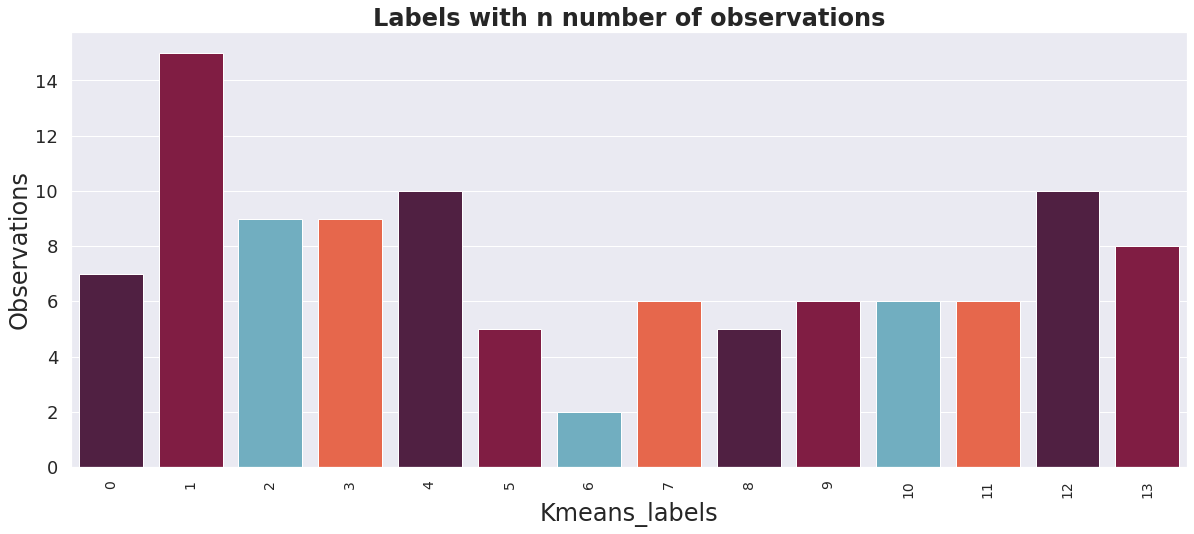

In [ ]:
# Visualization of Labels with n number of observations
labelsnobs(Kmeans_labels_count,Kmeans_labels_count['Kmeans_labels'],Kmeans_labels_count['Cuisines'],['#581845','#900C3F','C70039','#FF5733'],'Labels with n number of observations','Observations')

In [ ]:
# Getting terms
terms = vectorizer.get_feature_names()

In [ ]:
# Top terms(words) in  per cluster set
print('\033[1m' + 'Top terms in each cluster:' + '\033[0m')
cuisines_list = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(14):
  num = str(i)
  # print('\033[1m' + 'Cluster:' + '\033[0m',i, end='')
  print('\033[1m' + 'Cluster:' + num + '\033[0m', end='')
  for ind in order_centroids[i, :10]:
    cuisines_list.append(terms[ind])
  print(cuisines_list)
  cuisines_list = []

Top terms in each cluster:
Cluster:0['andhra', 'biryani', 'northindian', 'chines', 'lebanes', 'chinese', 'streetfood', 'arabian', 'hyderabadi', 'southindian']
Cluster:1['italian', 'continental', 'northindian', 'asian', 'chinese', 'salad', 'fingerfood', 'modernindian', 'mexican', 'spanish']
Cluster:2['fastfood', 'salad', 'northindian', 'pizza', 'burger', 'streetfood', 'burg', 'chinese', 'american', 'asian']
Cluster:3['chines', 'northindian', 'biryani', 'arabian', 'asian', 'dessert', 'continent', 'chinese', 'hyderabadi', 'burger']
Cluster:4['dessert', 'bakery', 'icecream', 'cafe', 'fastfood', 'mithai', 'wraps', 'juices', 'biryani', 'american']
Cluster:5['continent', 'northindian', 'chinese', 'healthyfood', 'goan', 'fingerfood', 'fastfood', 'european', 'dessert', 'continental']
Cluster:6['asian', 'bbq', 'modernindian', 'wraps', 'cafe', 'fingerfood', 'fastfood', 'european', 'desserts', 'dessert']
Cluster:7['american', 'burger', 'kebab', 'bakeri', 'chines', 'fingerfood', 'continental', 'nor

In [ ]:
# Grouping 'Kmeans_labels' and 'Name' feature
Kmeans_labels_name = pd.DataFrame(df.groupby(['Kmeans_labels'])['Name'],columns = ['KMeans_Cluster_labels','Restaurants'])
Kmeans_labels_name.set_index('KMeans_Cluster_labels', inplace=True)

In [ ]:
# Reataurant names with respect to each clusters
for i in range(0,14):
  num = str(i)
  print('\033[1m' + 'Cluster:'+ num + '\033[0m')
  print(Kmeans_labels_name['Restaurants'][i])

Cluster:0
7                Shah Ghouse Spl Shawarma
36    Banana Leaf Multicuisine Restaurant
37                    Kritunga Restaurant
45                            Owm Nom Nom
46                             Ulavacharu
84                                T Grill
89                    Mohammedia Shawarma
Name: Name, dtype: object
Cluster:1
5                                 The Fisherman's Wharf
13                        The Lal Street - Bar Exchange
21    Jonathan's Kitchen - Holiday Inn Express & Suites
26                               Mustang Terrace Lounge
34                Mazzo - Marriott Executive Apartments
38                                      The Glass Onion
40                                          Frio Bistro
53                                      Diners Pavilion
56                     Feast - Sheraton Hyderabad Hotel
60                                           PourHouse7
61                                 Prism Club & Kitchen
68                                The Tilt B

**Hierarchical Clustering**

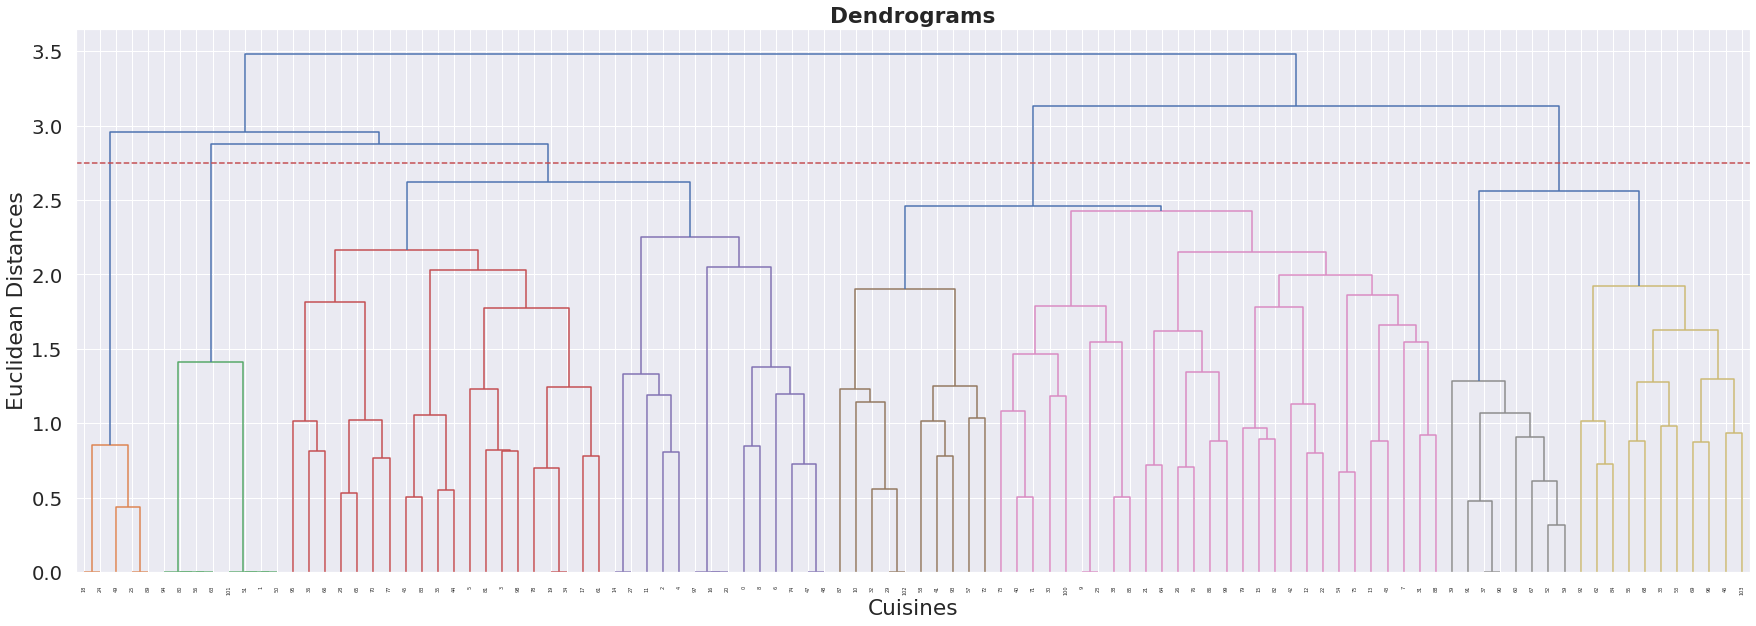

In [ ]:
# Hierarchical Clustering for 'Cuisine' feature
plt.figure(figsize=(30,10))
sns.set(font_scale = 1.8)
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.title('Dendrograms',fontweight = 'bold')
plt.xlabel('Cuisines')
plt.ylabel('Euclidean Distances')
plt.axhline(y=2.75, color='r', linestyle='--')
plt.show()

**Agglomerative Clustering**

In [ ]:
# To choose appropriate K value

for k in range(2,20):
  aggh = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
  aggh.fit(X)
  y_hc=aggh.fit_predict(X)
  print("For n_clusters =", k, "The average silhouette_score is :", round(silhouette_score(X, y_hc),5))

For n_clusters = 2 The average silhouette_score is : 0.06304
For n_clusters = 3 The average silhouette_score is : 0.07949
For n_clusters = 4 The average silhouette_score is : 0.1068
For n_clusters = 5 The average silhouette_score is : 0.10474
For n_clusters = 6 The average silhouette_score is : 0.11906
For n_clusters = 7 The average silhouette_score is : 0.12565
For n_clusters = 8 The average silhouette_score is : 0.12826
For n_clusters = 9 The average silhouette_score is : 0.13974
For n_clusters = 10 The average silhouette_score is : 0.15252
For n_clusters = 11 The average silhouette_score is : 0.16091
For n_clusters = 12 The average silhouette_score is : 0.17093
For n_clusters = 13 The average silhouette_score is : 0.18888
For n_clusters = 14 The average silhouette_score is : 0.19819
For n_clusters = 15 The average silhouette_score is : 0.20475
For n_clusters = 16 The average silhouette_score is : 0.20966
For n_clusters = 17 The average silhouette_score is : 0.21066
For n_clusters = 

In [ ]:
# The silhouette_score is reasonably good for k = 4

In [ ]:
# Creating an object for AgglomerativeClustering
aggh = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  

In [ ]:
# Fitting the model
aggh.fit(X)

AgglomerativeClustering(n_clusters=4)

In [ ]:
# Label Prediction
y_hc=aggh.fit_predict(X)

In [ ]:
# Labels
print(y_hc)

[0 0 0 0 0 0 0 2 0 2 2 0 2 2 0 2 0 0 3 0 0 2 2 2 3 3 2 0 0 2 2 2 2 1 0 0 0
 1 2 1 2 2 2 2 0 0 1 0 0 3 0 0 1 1 2 1 0 2 2 1 1 0 1 0 2 0 0 1 1 1 0 2 2 2
 0 2 2 0 0 2 0 0 2 0 1 2 2 2 2 3 1 1 1 2 0 0 1 0 0 2 2 0 2 1]


**DBSCAN Clustering**

In [ ]:
# Choosing appropriate min_samples
for samples in range(2,11):
  dbscan = DBSCAN(eps =0.89,min_samples =samples)
  db = dbscan.fit(X)
  dblabels = db.labels_
  print("For minimum samples =", samples, "The average silhouette_score is :", round(silhouette_score(X, dblabels),5))

For minimum samples = 2 The average silhouette_score is : 0.10726
For minimum samples = 3 The average silhouette_score is : 0.04557
For minimum samples = 4 The average silhouette_score is : 0.05662
For minimum samples = 5 The average silhouette_score is : 0.08984
For minimum samples = 6 The average silhouette_score is : 0.06116
For minimum samples = 7 The average silhouette_score is : 0.06116
For minimum samples = 8 The average silhouette_score is : 0.06113
For minimum samples = 9 The average silhouette_score is : 0.06113
For minimum samples = 10 The average silhouette_score is : 0.0481


Looks like we can go with **2** minimum samples

In [ ]:
# Creating instances for DBSCAN
dbscan = DBSCAN(eps =0.89,min_samples =2)

In [ ]:
# Model fit
db = dbscan.fit(X)

In [ ]:
# Storing labels in an object
dblabels = db.labels_
print(dblabels)

[ 0  1  1  1  1 -1 -1 -1  0  2 -1 -1  3  4  5 -1  6  1  7  1  6  8  3  2
  7  7  9  5  1  1 -1 -1  1  1  1  1  1  1 10 -1 11 11 -1  4  1  1 -1  1
  1  7  1  1  1 -1 12  1  1 -1 11  1  1  1 13  1  8  1  1  1  1 13  1 11
 -1 11  1 12  9  1  1 -1  1  1  3  1 13 10 14 -1 -1  7  1  1 13 11  1  1
 13  6  1 14 -1  1  1 -1]


In [ ]:
# Storing labels in 'DBSCAN_labels' feature
df['DBSCAN_labels'] = db.labels_

In [ ]:
# Silhouette score
print( "The average silhouette_score is :", round(silhouette_score(X, dblabels),5))

The average silhouette_score is : 0.10726


In [ ]:
# Creating an object with (n = len(dblabels)) number of Zeros
sample_cores = np.zeros_like(dblabels)

sample_cores[dbscan.core_sample_indices_] = True
# Calculating number of clusters
n_clusters = len(set(dblabels)) - (1 if -1 in dblabels else 0)

# Number of Clusters
print('Number of clusters:',n_clusters)

Number of clusters: 15


In [ ]:
# Creating a DataFrame for DBSCAN Labels visualization
DBSCAN_labels_count = pd.DataFrame(df.groupby('DBSCAN_labels')['Cuisines'].count()).reset_index()

# Filtering out outlier observations
DBSCAN_labels_count_copy = DBSCAN_labels_count[DBSCAN_labels_count['DBSCAN_labels'] == -1]

# Dropping observations that are labeled as Outliers by DBSCAN 
DBSCAN_labels_count = DBSCAN_labels_count.drop(DBSCAN_labels_count_copy.index, axis=0)

# print(labels_count)

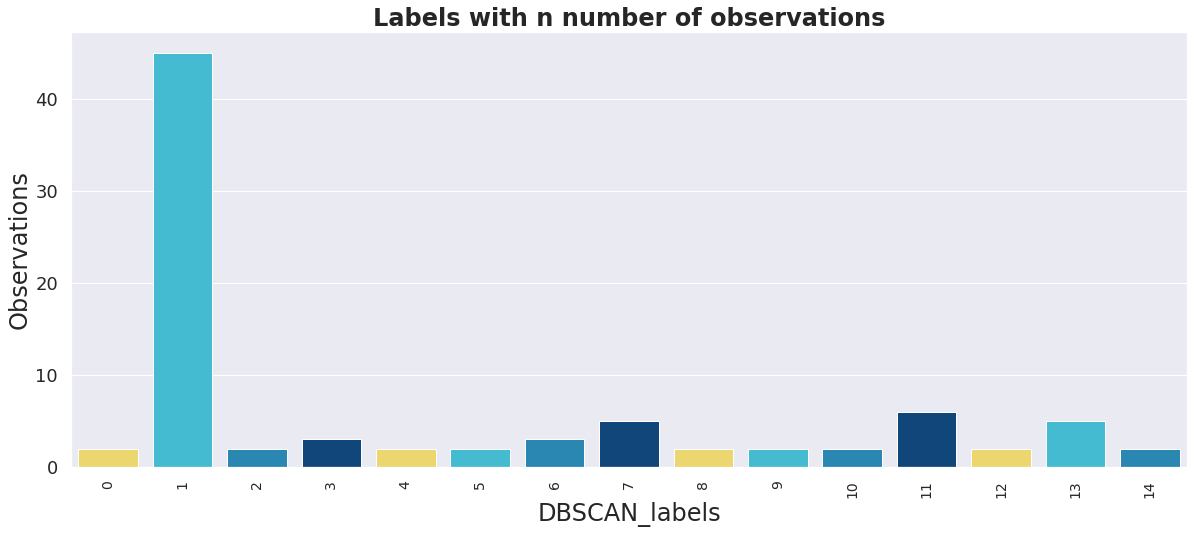

In [ ]:
# Visualization of Labels with n number of observations
labelsnobs(DBSCAN_labels_count,DBSCAN_labels_count['DBSCAN_labels'],DBSCAN_labels_count['Cuisines'],['#FFE45C','#2ECBE9','#128FC8','#00468B'],'Labels with n number of observations','Observations')

In [ ]:
# Grouping 'DBSCAN_labels' and 'Name' feature
dbscan_labels_name = pd.DataFrame(df.groupby(['DBSCAN_labels'])['Name'],columns = ['dbscan_Cluster_labels','Restaurants'])
# Assigning 'dbscan_Cluster_labels' feature as index
dbscan_labels_name.set_index('dbscan_Cluster_labels', inplace=True)

In [ ]:
# Reataurant names with respect to each clusters
for i in range(0,15):
  num = str(i)
  print('\033[1m' + 'Cluster:' + num + '\033[0m')
  print(dbscan_labels_name['Restaurants'][i])

Cluster:0
0    Beyond Flavours
8        Hyper Local
Name: Name, dtype: object
Cluster:1
1                                     Paradise
2                                     Flechazo
3               Shah Ghouse Hotel & Restaurant
4                   Over The Moon Brew Company
17                            Hotel Zara Hi-Fi
19                               Pakwaan Grand
28                             Behrouz Biryani
29                          Hunger Maggi Point
33                                  Club Rogue
34       Mazzo - Marriott Executive Apartments
35                   Green Bawarchi Restaurant
36         Banana Leaf Multicuisine Restaurant
37                         Kritunga Restaurant
38                             The Glass Onion
45                                 Owm Nom Nom
46                                  Ulavacharu
48                              Udipi's Upahar
49                               Mathura Vilas
51                   Hitech Bawarchi Food Zone
52                 

**Loading Zomato Restaurant Reviews CSV file**

In [ ]:
# Loading the CSV file
df_r = pd.read_csv('/content/Mydrive/MyDrive/Capstone_Project_Unsupervised_ML_Zomato_Restaurant_Clustering_and_Sentiment_Analysis/Zomato Restaurant reviews.csv')

In [ ]:
# Shape
df_r.shape

(10000, 7)

In [ ]:
# Head
df_r.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [ ]:
# Info
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [ ]:
# Null values treatment
# Dropping rows with Null values
df_r = df_r.dropna(axis =0)

In [ ]:
# Some observations in 'Rating' feature contains a String 'Like'
# Dropping row with string('Like') in rating
i = df_r[df_r['Rating']=='Like'].index
print('Index of the observation with String "Like":',i)
df_r.drop(i,inplace=True)

Index of the observation with String "Like": Int64Index([7601], dtype='int64')


In [ ]:
# Converting 'Rating' feature to Float datatype
df_r['Rating'] = df_r['Rating'].apply(lambda x: float(x))

In [ ]:
# df_r.info()

In [ ]:
# Summary
df_r.describe()

,Rating,Pictures
count,9954.000000,9954.000000
mean,3.600261,0.751959
std,1.483573,2.575819
min,1.000000,0.000000
25%,3.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,64.000000


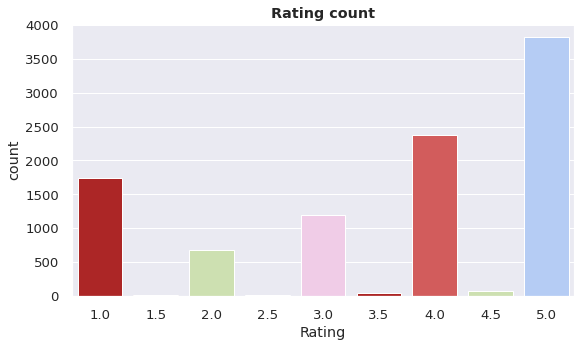

In [ ]:
# Count plot for Rating
plt.figure(figsize = (9,5))
sns.set(font_scale = 1.2)
sns.countplot(x='Rating',data = df_r,palette = ['#C21010','#E64848','#CFE8A9','#ABC9FF','#F6C6EA'])
plt.title('Rating count',fontweight = 'bold')
plt.show()

In [ ]:
# Almost 75% of the ratings are good.

In [ ]:
# Creating a feature to store the length of the reviews
df_r['Review_length'] = df_r['Review'].apply(len)

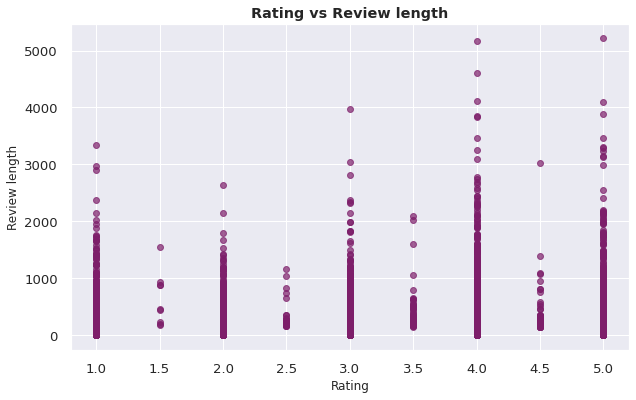

In [ ]:
# Scatter plot for Rating vs Review length
plt.figure(figsize=(10,6))
plt.scatter(x=df_r['Rating'],y=df_r['Review_length'],color= '#7D1E6A',alpha = 0.7)
xticks = [1,1.5,2,2.5,3,3.5,4,4.5,5]
plt.title('Rating vs Review length',fontweight = 'bold')
plt.xlabel('Rating',fontsize = 12)
plt.ylabel('Review length',fontsize = 12)
plt.xticks(xticks)
plt.show()

In [ ]:
# From the above scatter plot we could see the Rating doesn't dependent on Review length

In [ ]:
# df_r.head()

In [ ]:
df_r.reset_index(inplace = True)

In [ ]:
# Downloading stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Stop words
stop_words = stopwords.words('english')
# Rest words
rest_word = ['order','restaurant','taste','ordered','good','food','table','place','one','also']

In [ ]:
df_r['Reviews_txt_processed'] = df_r['Review'] 

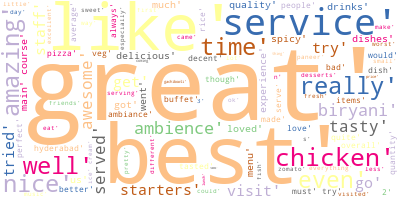

In [ ]:
# Wordcloud for Reviews
# df_r['Review'] = df_r['Review'].astype(str)
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: re.sub('[,\.!?]','', x))
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: x.lower())
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: x.split())
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].apply(lambda x: [words for words in x if words not in stop_words])
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].apply(lambda x: [words for words in x if words not in rest_word])
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].astype(str)

ps = PorterStemmer() 
long_string = ','.join(list(df_r['Reviews_txt_processed'].values))
# print(long_string)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Positive Reviews(Ratings greater than 3)
pos_rev = df_r[df_r['Rating'] > 3]

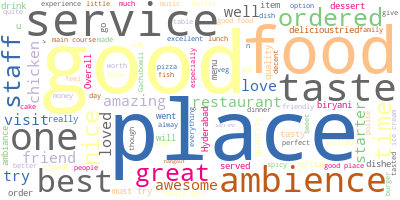

In [ ]:
# Wordcloud for Positive reviews
long_string = ','.join(list(pos_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Negative Reviews(Ratings lesser than 3)
neg_rev = df_r[df_r['Rating'] < 3]

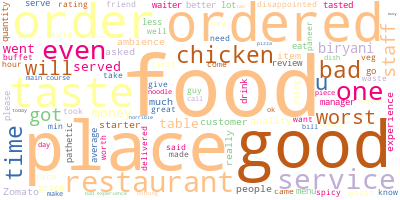

In [ ]:
# Wordcloud for Negative reviews
long_string = ','.join(list(neg_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Extracting the number of reviews
df_r['Metadata'] = df_r['Metadata'].str.split(' ')
df_r['Metadata'] = df_r['Metadata'].apply(lambda x: x[0])
df_r['Metadata'] = df_r['Metadata'].apply(lambda x : int(x))

In [ ]:
# Creating a dataframe to store top 10 reviewers
top_reviewers = pd.DataFrame(df_r.groupby(['Reviewer','Metadata']).sum()).reset_index()
top_reviewers = top_reviewers.sort_values(by = 'Metadata',ascending = False)
top_reviewers = top_reviewers[:15]
# print(top_reviewers)

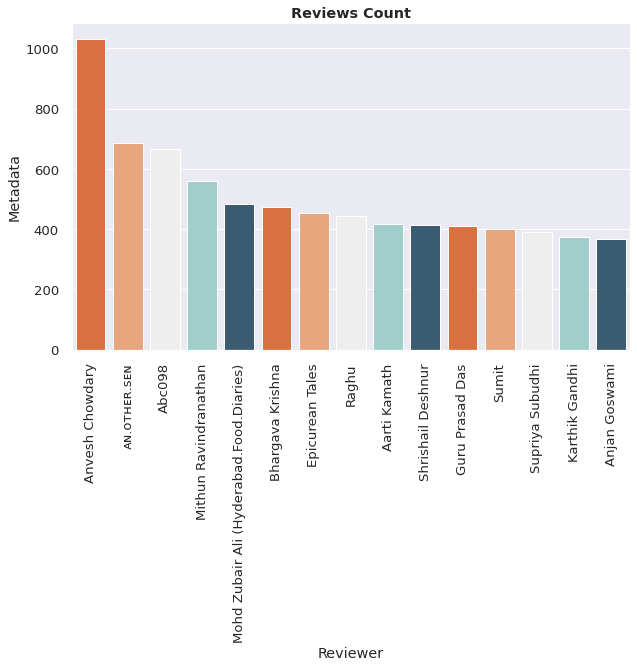

In [ ]:
# Visualization of top 10 reviewers
plt.figure(figsize = (10,6))
sns.barplot(data = top_reviewers,x = 'Reviewer',y = 'Metadata',palette = ['#F26627','#F9A26C','#EFEEEE','#98D7D1','#325D79'])
plt.title('Reviews Count',fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# Top 10 Restaurants with high average rating
df_r['Rating'] = df_r['Rating'].apply(lambda x: float(x))
avg_ratings = pd.DataFrame(df_r.groupby('Restaurant')['Rating'].mean()).reset_index()
avg_ratings = avg_ratings.sort_values(by = 'Rating',ascending = False)
avg_ratings = avg_ratings[:10]

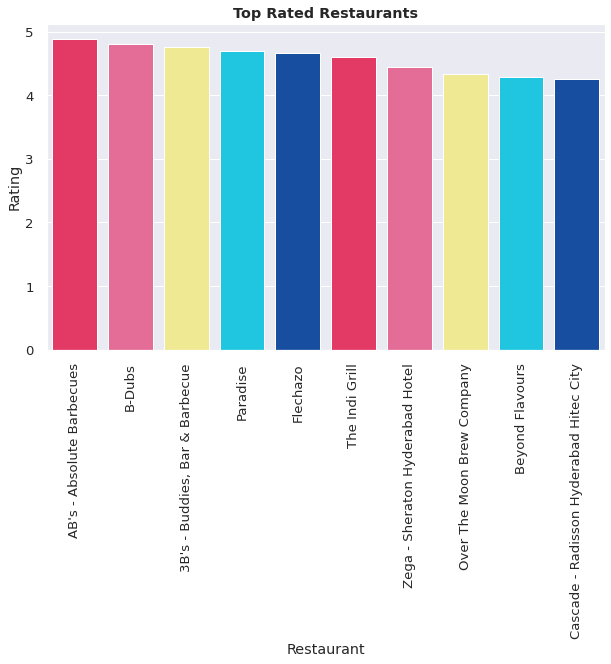

In [ ]:
# Visualization of top 10 reviewers
plt.figure(figsize = (10,6))
sns.barplot(data = avg_ratings,x = 'Restaurant',y = 'Rating',palette = ['#FF1D58','#F75990','#FFF685','#00DDFF','#0049B7'])
plt.title('Top Rated Restaurants',fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

## **Sentiment Analysis**


**Merging both datasets**

In [ ]:
# shape of two dataframes
print(df.shape)
print(df_r.shape)

(104, 7)
(9954, 10)


In [ ]:
# Storing unique Restaurants from 'Zomato Restaurant names and Metadata' dataframe
rest_names_lst = list(df['Name'].unique())

In [ ]:
# Length of Restaurants
print('Unique Restaurants from "Zomato Restaurant names and Metadata" dataframe:',len(rest_names_lst))

Unique Restaurants from "Zomato Restaurant names and Metadata" dataframe: 104


In [ ]:
# Storing unique Restaurans from 'Zomato Restaurant reviews' dataframe
rest_names_lsts = list(df_r['Restaurant'].unique())

In [ ]:
# Length of Restaurants
print('Unique Restaurants from "Zomato Restaurant reviews" dataframe:',len(rest_names_lsts))

Unique Restaurants from "Zomato Restaurant reviews" dataframe: 100


In [ ]:
# Zomato Restaurant names and Metadata has 104 unique Restaurants.
# Zomato Restaurant reviews has 100 unique Restaurants.
# For merging two dataframes we are to remove non-common Restaurants.
# Storing non common restaurants in lst.
lst = []
for name in rest_names_lst:
  if name not in rest_names_lsts:
    lst.append(name)

In [ ]:
# List of non-common Restaurants
print('Non common Restaurants:',lst)

Non common Restaurants: ['IndiBlaze', 'Sweet Basket', 'Angaara Counts 3', 'Wich Please', 'Republic Of Noodles - Lemon Tree Hotel']


In [ ]:
# Filtering out rows 
final = df
for not_com_rest_names in lst:
  final = final[final['Name'] != not_com_rest_names]

In [ ]:
# Renaming the column 'Restaurant'
df_r.rename(columns = {'Restaurant':'Name'}, inplace = True)

In [ ]:
# Merging two dataframes
merged_df = pd.merge(df_r, final, how='left', on='Name')

In [ ]:
# Droping less significant features
merged_df.drop(['Time','Metadata','Links','Timings','Kmeans_labels','DBSCAN_labels'],axis = 1,inplace = True)

In [ ]:
# Re-indexing the columns
merged_df = merged_df.reindex(columns=['index','Name', 'Reviewer','Review','Reviews_txt_processed','Review_length','Rating','Polarity','Cost','Cuisines'])

In [ ]:
# Shape
merged_df.shape

(9954, 10)

In [ ]:
# Head
merged_df.head(2)

,index,Name,Reviewer,Review,Reviews_txt_processed,Review_length,Rating,Polarity,Cost,Cuisines
0,0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...","['ambience', 'quite', 'saturday', 'lunch', 'co...",222,5.0,NaN,800.0,chinese continental kebab european southindian...
1,1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,"['ambience', 'pleasant', 'evening', 'service',...",144,5.0,NaN,800.0,chinese continental kebab european southindian...


In [ ]:
# Info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  9954 non-null   int64  
 1   Name                   9954 non-null   object 
 2   Reviewer               9954 non-null   object 
 3   Review                 9954 non-null   object 
 4   Reviews_txt_processed  9954 non-null   object 
 5   Review_length          9954 non-null   int64  
 6   Rating                 9954 non-null   float64
 7   Polarity               0 non-null      float64
 8   Cost                   9854 non-null   float64
 9   Cuisines               9854 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 855.4+ KB


In [ ]:
# Creating dataframe to store avg rating and avg cost for each reataurant
ratingncost = pd.DataFrame(merged_df.groupby('Name')['Rating','Cost'].mean()).reset_index()
# print(ratingncost)

In [ ]:
# Visualization of Restaurant Cost vs Rating
# plt.figure(figsize=(40,10))
fig = px.bar(ratingncost, x="Name", y="Cost",color="Rating",width=900, height=700)
fig.update_xaxes(ticks="outside", tickwidth=1, tickcolor='pink',tickangle=90, ticklen=10)
fig.update_layout(title_text="Restaurant Cost vs Rating")
fig.show()

**Vader Model**

In [ ]:
# Text Preprocessing for Vader Model

In [ ]:
# Tokenizer
tokenizer_vader = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer_vader.fit_on_texts(merged_df['Review'])

In [ ]:
# merged_df.head(2)

In [ ]:
# Appling text processing function
merged_df['Review'] = merged_df['Review'].apply(normalize)

In [ ]:
# Replacing comma
merged_df['Review'] = merged_df['Review'].apply(lambda x: ','.join(x))
merged_df['Review'] = merged_df['Review'].apply(lambda x: x.replace(',',''))

In [ ]:
# Function for removing Stopwords
def remove_stop_words(col_name):
  stop = stopwords.words('english')
  merged_df[col_name] = merged_df[col_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Applying function to remove stopwords
remove_stop_words('Review')

In [ ]:
# merged_df.head(2)

In [ ]:
# Creating an object for SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
# Applying 'SentimentIntensityAnalyzer' for Reviews
merged_df['SIA_polarity'] = merged_df['Review'].apply(lambda x: sia.polarity_scores(x))

In [ ]:
# Function for extracting Polarity values
def SIA_ploaritysep(new_col,dict_key):
  merged_df[new_col] = merged_df['SIA_polarity'].apply(lambda x: x[dict_key])

In [ ]:
# Applying 'nltkploaritysep' function
SIA_ploaritysep('SIA_Compound','compound')
SIA_ploaritysep('SIA_Positive','pos')
SIA_ploaritysep('SIA_Neutral','neu')
SIA_ploaritysep('SIA_Negative','neg')

In [ ]:
# Function for bar plot in vader dataframe
def barplotpolarity(x,y,palette):
  plt.figure(figsize = (10,7))
  sns.barplot(data = merged_df,x = x,y = y,palette = palette)
  plt.show()

In [ ]:
# merged_df.head()

In [ ]:
# Neagtive Polarity
barplotpolarity('Rating','SIA_Negative',['#2A0944','#3FA796','#FEC260','#A10035'])

From the above graph we could clearly see the decrease in Negative polarity with increase in Rating.

In [ ]:
# Compound Polarity
barplotpolarity('Rating','SIA_Compound',['#BDF2D5','#4B5D67','#3C2C3E','#FF06B7'])

From the above graph we could clearly see the increase in Compound polarity with increase in Rating.

In [ ]:
# Positive Polarity
barplotpolarity('Rating','SIA_Positive',['#FFCC00','#FF6666','#CC0066','#66CCCC'])

From the above graph we could clearly see the increase in Positive polarity with increase in Rating.

In [ ]:
# Neutral Polarity
barplotpolarity('Rating','SIA_Neutral',['#0A043C','#03506F','#BBBBBB','#FFE3D8'])

From the above graph we could clearly see the kind of no difference in Neutral polarity with the Rating.

In [ ]:
# Function for Polarity Distribution plot
def dist_polarity(df,xlabel,color):
  plt.figure(figsize=(8,5))
  xticks = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
  sns.distplot(df,bins = 100,color= color)
  plt.title('Distribution plot for Polarity',fontsize = 12,fontweight = 'bold')
  plt.xlabel(xlabel,fontsize = 12)
  plt.ylabel('Density',fontsize = 12)
  plt.xticks(xticks,fontsize = 8)
  plt.show()

In [ ]:
# SIA distribution plot
dist_polarity(merged_df['SIA_Compound'],'SIABlob_Polarity','crimson')

In [ ]:
# Mapping the sentiments.
# Positive for SIA_Compound > 0
# Negative for SIA_Compound < 0
# Neutral for SIA_Compound = 0
merged_df['SIA_Sentiment'] = merged_df['SIA_Compound'].apply(lambda x: 'Positive' if (x > 0) else ('Negative' if (x<0) else 'Neutral'))

In [ ]:
# Function for pie chart
def piechart(df,colors):
  pos = (df.value_counts()[0]/df.count())*100
  neg = (df.value_counts()[1]/df.count())*100
  neu = (df.value_counts()[2]/df.count())*100
  # Pie chart for Percentage of Reviews Sentiment
  plt.figure(figsize = (10,6))
  myexplode = [0.05, 0.05, 0.05]
  plt.pie([pos,neg,neu],labels = ['Positive','Neutral','Negative'],autopct='%1.1f%%',explode = myexplode,colors =colors,)
  plt.title('Percentage of Reviews Sentiment')
  plt.show()

In [ ]:
# Pie chart
piechart(merged_df['SIA_Sentiment'],colors = ['#2CF6B3','#BE61CA','#F13C59'])

In [ ]:
# Reviews Sentiment
merged_df['SIA_Sentiment'].value_counts()

In [ ]:
# Function for plotting most common words in different sentiments
def word_frequency(df,ylim1,ylim2,title,color):
  vectorizer = TfidfVectorizer(stop_words='english')

  temp = df
  corpus = []
  temp['Review'].apply(lambda x: corpus.append(x))

  text = []
  freq = []
  X = vectorizer.fit_transform(corpus)
  # this will give you words instead of tfidf where tfidf > 0
  X_words = vectorizer.inverse_transform(X) 
  # return tokenizer function used in tfidfvectorizer
  tokenizer = vectorizer.build_tokenizer()

  for idx,words in enumerate(X_words):
      for word in words:
          count = tokenizer(corpus[idx]).count(word)
          text.append(word)
          freq.append(count)
          # print(type(word))
          # print(idx,word,count)


  # Creating a dataframe to store the words and its frequency 
  words_counts = pd.DataFrame(freq,text).reset_index()
  words_counts.rename({0:'Frequency'},axis = 1,inplace = True)
  words_counts = words_counts.groupby('index').sum()
  words_counts.sort_values(by = 'Frequency',ascending = False,inplace = True)
  words_counts = words_counts.reset_index()
  # Plotting
  plt.figure(figsize = (10,8))
  plot = sns.barplot(data = words_counts.iloc[0:20],x = 'index',y = 'Frequency',palette = color)
  plt.title(title)
  plt.xticks(rotation = 90)
  plot.set(ylim=(ylim1, ylim2))
  plt.show()

In [ ]:
# Most Common words in Positive Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Positive'],0,7000,'Most Common words in Positive Sentiment',
             ['#FF1E00','#FF8B8B','#E8F9FD','#FFDEDE','#59CE8F','#ABC9FF','#000000'])

In [ ]:
# Most Common words in Negative Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Negative'],0,1000,'Most Common words in Negative Sentiment',
             ['#4E944F','#83BD75','#B4E197','#E9EFC0'])

In [ ]:
# Most Common words in Neutral Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Neutral'],0,120,'Most Common words in Neutral Sentiment',
             ['#034561','#409D9B','#4FB783','#FEEB97'])

In [ ]:
# Most Common words in Highly Positive Sentiment
word_frequency(merged_df[merged_df['SIA_Positive'] > 0.90],0,350,'Most Common words in Highly Positive Sentiment',
             ['#7C3E66','#F2EBE9','#A5BECC','#243A73'])

In [ ]:
# Most Common words in Highly Negative Sentiment
word_frequency(merged_df[merged_df['SIA_Negative'] > 0.80],0,20,'Most Common words in Highly Negative Sentiment',
             ['#E63870','#FBE6A2','#58E481','#8AB2FF'])

In [ ]:
# Restaurants with more number of positive reviews
rest_pos = pd.DataFrame(merged_df[merged_df['SIA_Sentiment'] == 'Positive'].groupby('Name')['index'].count()).reset_index()
rest_pos.sort_values(by = 'index',ascending = False,inplace = True)
rest_pos.rename({'index':'count'},axis = 1,inplace = True)

In [ ]:
 # Plot
def restuarants(df,title,ylim1,ylim2,color):
  plt.figure(figsize = (14,6))
  plot = sns.barplot(data = df,x = 'Name',y = 'count',palette = color)
  plt.title(title)
  plt.xticks(rotation = 90)
  plot.set(ylim=(ylim1, ylim2))
  plt.show()

In [ ]:
# Plotting the Restaurants with more number of positive reviews
restuarants(rest_pos.iloc[0:50],'Restaurants with more number of positive reviews',60,100,
            ['#D1F6A4','#F99A9A','#FECB92','#F1F5BC','#1684A7','#09A599','#F6EC72'])

In [ ]:
# Plotting the Restaurants with more number of negative reviews
restuarants(rest_pos.iloc[-50:],'Restaurants with more number of negative reviews',0,80,
            ['#AA1111','#B15858','#F2C280','#FF8C32','#FCF8A6','#FD9191','#9EFCB4'])

In [ ]:
# merged_df.describe()

In [ ]:
# Function for Restaurnts with best ratings
def restaurants_best(rating,ascending):
  temp = pd.DataFrame(merged_df.groupby('Name')['Cost','Rating'].mean()).reset_index()
  temp = temp[temp['Rating'] > rating]
  temp.sort_values(by = ['Cost','Rating'],ascending = ascending,inplace = True)
  return temp.head()

In [ ]:
# Function for Restaurnts with worst ratings
def restaurants_worst(rating,ascending):
  temp = pd.DataFrame(merged_df.groupby('Name')['Cost','Rating'].mean()).reset_index()
  temp = temp[temp['Rating'] < rating]
  temp.sort_values(by = ['Cost','Rating'],ascending = ascending,inplace = True)
  return temp.head()

In [ ]:
# Top 5 Affordable Restaurants with best ratings
restaurants_best(4,True)

In [ ]:
# Top 5 Affordable Restaurants with worst ratings
restaurants_worst(2.9,True)

In [ ]:
# Top 5 Expensive Restaurants with best ratings
restaurants_best(4,False)

In [ ]:
# Top 5 Expensive Restaurants with worst ratings
restaurants_worst(3,False)

**TextBlob Model**

In [ ]:
# Applying TextBlob Model
merged_df['TextBlob_Polarity'] = merged_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# SIA distribution plot
dist_polarity(merged_df['TextBlob_Polarity'],'TextBlob_Polarity','#5416B4')

In [ ]:
# We can clearly see that most of the Reviews are 'Neutral' or 'Positive'

In [ ]:
# Mapping the sentiment as Positive for SIA_Sentiment > 0
# Positive for TextBlob_Polarity > 0
# Negative for TextBlob_Polarity < 0
# Neutral for TextBlob_Polarity = 0
merged_df['TextBlob_Sentiment'] = merged_df['TextBlob_Polarity'].apply(lambda x: 'Positive' if (x > 0) else ('Negative' if (x<0) else 'Neutral'))

In [ ]:
# Pie chart
piechart(merged_df['TextBlob_Sentiment'],colors = ['#395B64','#A5C9CA','#E7F6F2'])

In [ ]:
# Reviews Sentiment
merged_df['TextBlob_Sentiment'].value_counts()

In [ ]:
# Most Common words in Highly Positive Sentiment
word_frequency(merged_df[merged_df['TextBlob_Polarity'] > 0.80],0,140,'Most Common words in Highly Positive Sentiment',
             ['#092A35','#658525','#CFEE91','#F8EEB4'])

In [ ]:
# Most Common words in Highly Negative Sentiment
word_frequency(merged_df[merged_df['TextBlob_Polarity'] < -0.80],0,70,'Most Common words in Highly Negative Sentiment',
             ['#FF2E63','#FF9D9D','#FFC2C2','#010A43'])

**Model Comparison**

In [ ]:
model_com = pd.DataFrame((merged_df['TextBlob_Polarity'],merged_df['SIA_Compound'])).T.reset_index()

In [ ]:
# model_com.head()

In [ ]:
# Scatter plot for model comparison
plt.figure(figsize = (10,6))
plt.scatter(data = model_com, x = 'TextBlob_Polarity', y = 'SIA_Compound',color = 'purple',alpha = 0.7)
plt.title('Model Comparison')
plt.xlabel('TextBlob Polarity')
plt.ylabel('Vader Polarity')
plt.show()